In [174]:
import archetypes as arch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd

In [175]:
data = pd.read_csv("data/enron_mails_adjacency_matrix.csv", index_col=0)
data[data != 0] = 1

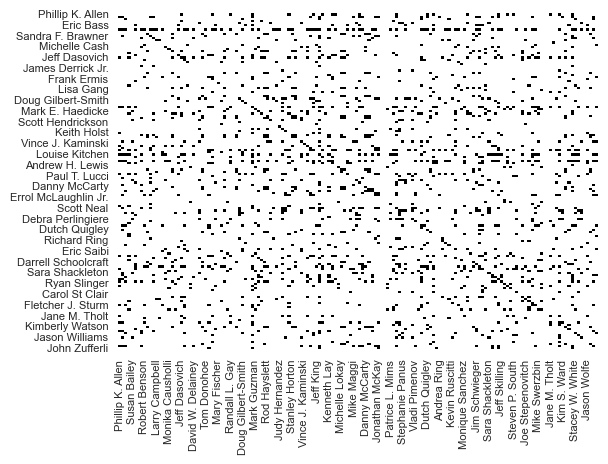

In [176]:
cmap = ListedColormap(['w', 'k'])

sns.heatmap(data, cmap=cmap, vmin=0, vmax=1, cbar=False)
plt.rcParams.update({'font.size': 8})
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.25, top=0.95)
plt.show()

In [177]:
X = data.to_numpy().astype("f")

# add a dummy column with all zeros
X_zero = np.hstack((X, np.zeros((X.shape[0], 1), dtype="f")))

## BiArchetype Analysis

In [178]:
biaa = arch.BiAA(n_archetypes=(6, 6), max_iter=10_000, n_init=5, random_state=123)
_ = biaa.fit(X)

In [179]:
biaa_row_probs = biaa.alphas_
biaa_col_probs = biaa.gammas_.T

In [180]:
biaa_row_rep = biaa_row_probs.argmax(axis=0)
biaa_col_rep = biaa_col_probs.argmax(axis=0)

## Louvain method

In [181]:
from sknetwork.clustering import Louvain

louvain = Louvain(resolution=1.0, n_aggregations=5, sort_clusters=True)
louvain.fit(X_zero)

labels = louvain.labels_
labels_col = louvain.labels_col_

In [182]:
louvain_row_probs = louvain.predict_proba(columns=False)
louvain_col_probs = louvain.predict_proba(columns=True)

In [183]:
louvain_row_rep = louvain_row_probs.argmax(axis=0)
louvain_col_rep = louvain_col_probs.argmax(axis=0)

## Spectral Biclustering

In [184]:
# import spatial coclustering

from sklearn.cluster import SpectralBiclustering

biclus = SpectralBiclustering(n_clusters=(5, 5), method='log', random_state=0)
_ = biclus.fit(X)

c:\Users\aalcacer\Miniconda3\envs\archetypes\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\aalcacer\Miniconda3\envs\archetypes\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\aalcacer\Miniconda3\envs\archetypes\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\aalcacer\Miniconda3\envs\archetypes\lib\site-packages\sklearn\clust

In [185]:
biclus_row_labels = biclus.row_labels_
biclus_column_labels = biclus.column_labels_

In [186]:
from scipy.spatial.distance import cdist

biclus_row_rep = np.zeros(biclus.n_clusters[0], dtype=int)
for i in range(biclus.n_clusters[0]):
    row_indices, _ = biclus.get_indices(i * biclus.n_clusters[1])
    biclus_row_rep[i] = row_indices[cdist(X[row_indices, :], X[row_indices, :]).sum(axis=1).argmin()]

biclus_col_rep = np.zeros(biclus.n_clusters[1], dtype=int)
for j in range(biclus.n_clusters[1]):
    _, col_indices = biclus.get_indices(j)
    biclus_col_rep[j] = col_indices[cdist(X[:, col_indices].T, X[:, col_indices].T).sum(axis=1).argmin()]


## Spectral Co-clustering

In [187]:
# remove if X has rows or columns with only zeros

X_co = X.copy()
X_co = X_co[(X != 0).sum(axis=1) > 0, :]
X_co = X_co[:, (X != 0).sum(axis=0) > 0]


In [188]:
# import spatial coclustering

from sklearn.cluster import SpectralCoclustering

coclus = SpectralCoclustering(n_clusters=(5), random_state=2)
_ = coclus.fit(X_co)

c:\Users\aalcacer\Miniconda3\envs\archetypes\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [189]:
coclus_row_labels = coclus.row_labels_
coclus_column_labels = coclus.column_labels_

In [190]:
from scipy.spatial.distance import cdist

coclus_row_rep = np.zeros(coclus.n_clusters, dtype=int)
coclus_col_rep = np.zeros(coclus.n_clusters, dtype=int)

for i in range(coclus.n_clusters):
    row_indices, col_indices = coclus.get_indices(i)
    coclus_row_rep[i] = row_indices[cdist(X[row_indices, :], X[row_indices, :]).sum(axis=1).argmin()]
    coclus_col_rep[i] = col_indices[cdist(X[:, col_indices].T, X[:, col_indices].T).sum(axis=1).argmin()]


## PCA

In [191]:
rep_marker = "+"
rep_s = 100

from matplotlib import colormaps
rep_cmap = colormaps.get_cmap('Dark2')

In [192]:
def jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [209]:
def plot_convex_hull(points, color, ax):
    from scipy.spatial import ConvexHull
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], color=color, alpha=0.2)

    # fill hull
    ax.fill(points[hull.vertices, 0], points[hull.vertices, 1], color=color, alpha=0.05)

    # compute the area of the hull
    area = hull.volume

    # annotate in one of the vertices
    # ax.text(points[hull.vertices[0], 0], points[hull.vertices[0], 1], f'{area:.2f}', fontsize=8, color=color)

    return ax


### Senders

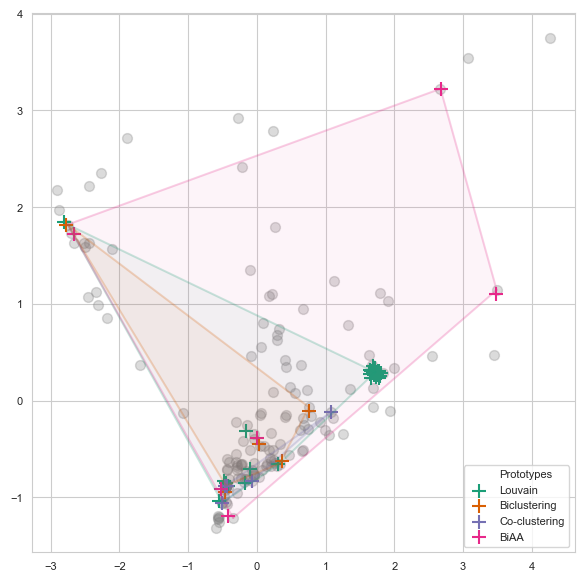

In [213]:
# Apply PCA to X

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)

X_2d = X_pca


plt.figure(figsize=(7, 7))


plt.scatter(X_2d[:, 0], X_2d[:, 1], s=50, color="gray", alpha=.1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=50, color="gray", alpha=.1)
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=50, color="gray", alpha=.1)

# plt.scatter(X_2d[target_0, 0], X_2d[target_0, 1], s=50, color="gray", alpha=.1, marker='o', label=target_names[0])
# plt.scatter(X_2d[target_1, 0], X_2d[target_1, 1], s=50, color="gray", alpha=.1, marker='s', label=target_names[1])
# plt.scatter(X_2d[target_2, 0], X_2d[target_2, 1], s=50, color="gray", alpha=.1, marker='^', label=target_names[2])

# plot louvain rep
plt.scatter(
    jitter(X_2d[louvain_row_rep, 0]),
    jitter(X_2d[louvain_row_rep, 1]),
    s=rep_s, color=rep_cmap(0), marker=rep_marker, label='Louvain')

# plot biclus medoids
plt.scatter(
    jitter(X_2d[biclus_row_rep, 0]),
    jitter(X_2d[biclus_row_rep, 1]),
    s=rep_s, color=rep_cmap(1), marker=rep_marker, label='Biclustering')

# plot coclus medoids
plt.scatter(
    jitter(X_2d[coclus_row_rep, 0]),
    jitter(X_2d[coclus_row_rep, 1]),
    s=rep_s, color=rep_cmap(2), marker=rep_marker, label='Co-clustering')

# plot biaa rep
plt.scatter(
    jitter(X_2d[biaa_row_rep, 0]),
    jitter(X_2d[biaa_row_rep, 1]),
    s=rep_s, color=rep_cmap(3), marker=rep_marker, label='BiAA')

# plot convex hulls
plot_convex_hull(X_2d[louvain_row_rep], rep_cmap(0), plt.gca())
plot_convex_hull(X_2d[biclus_row_rep], rep_cmap(1), plt.gca())
plot_convex_hull(X_2d[coclus_row_rep], rep_cmap(2), plt.gca())
plot_convex_hull(X_2d[biaa_row_rep], rep_cmap(3), plt.gca())

plt.legend()

# Get legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

from matplotlib.lines import Line2D
# Add a title in the position 0 of the legend

handles.insert(0, Line2D([0],[0],color="w"))
labels.insert(0, 'Prototypes')


plt.legend(handles, labels, loc='lower right', ncol=1)

# save figure as pdf
plt.savefig('../figures/pca_enron_1.pdf', bbox_inches='tight')

plt.show()


### Receivers

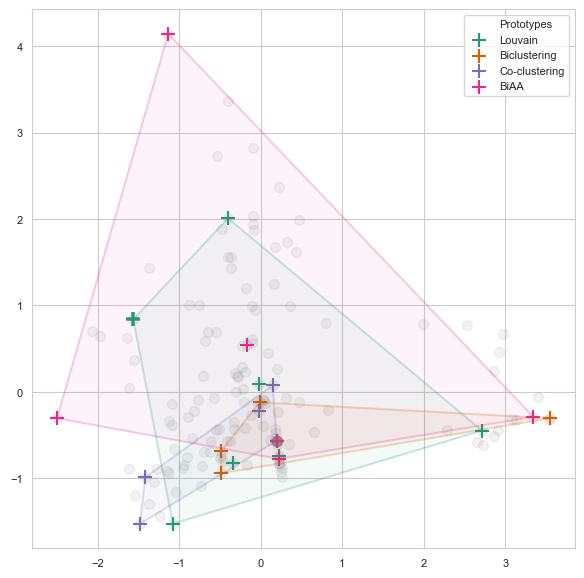

In [211]:
# Apply PCA to X

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X.T)

X_2d = X_pca

# plot the results
from adjustText import adjust_text

plt.figure(figsize=(7, 7))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=50, c="gray", alpha=0.1)


# plot louvain rep
plt.scatter(X_2d[louvain_col_rep, 0], X_2d[louvain_col_rep, 1], s=rep_s, color=rep_cmap(0), marker=rep_marker, label='Louvain')

# plot biclus medoids
plt.scatter(X_2d[biclus_col_rep, 0], X_2d[biclus_col_rep, 1], s=rep_s, color=rep_cmap(1), marker=rep_marker, label='Biclustering')

# plot coclus medoids
plt.scatter(X_2d[coclus_col_rep, 0], X_2d[coclus_col_rep, 1], s=rep_s, color=rep_cmap(2), marker=rep_marker, label='Co-clustering')

# plot biaa rep
plt.scatter(X_2d[biaa_col_rep, 0], X_2d[biaa_col_rep, 1], s=rep_s, color=rep_cmap(3), marker=rep_marker, label='BiAA')


# plot convex hulls
plot_convex_hull(X_2d[louvain_col_rep], rep_cmap(0), plt.gca())
plot_convex_hull(X_2d[biclus_col_rep], rep_cmap(1), plt.gca())
plot_convex_hull(X_2d[coclus_col_rep], rep_cmap(2), plt.gca())
plot_convex_hull(X_2d[biaa_col_rep], rep_cmap(3), plt.gca())

plt.legend()

# Get legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

from matplotlib.lines import Line2D
# Add a title in the position 0 of the legend
handles.insert(0, Line2D([0],[0],color="w"))
labels.insert(0, 'Prototypes')

plt.legend(handles, labels, loc='upper right')

# save figure as pdf
plt.savefig('../figures/pca_enron_2.pdf', bbox_inches='tight')

plt.show()
